# CS-E4600 — Programming project

## Imports

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Read file

In [84]:
file = 'CA-GrQc.txt'

## Read Edges

In [85]:
pd_edges = pd.read_csv('./graphs_processed/' + file, sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

## Select Distinct Nodes

In [86]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [87]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes to Numpy

In [111]:
nodes = pd_nodes.values
edges = pd_edges.values
#nodes.shape, edges.shape

## Create Adjacency Matrix

In [122]:
adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

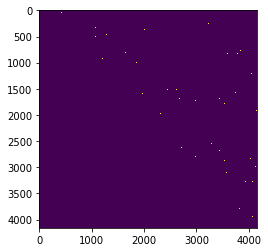

In [126]:
for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
#np.sum(adjacency_matrix)
plt.imshow(adjacency_matrix)

## Create Laplacian Matrix